In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import FinanceDataReader as fdr

In [3]:
import plotly.express as px
import plotly.graph_objects as go

In [4]:
def get_returns_df(df, N=1, log=False):
    if log:
        return np.log(df/df.shift(N)).iloc[N-1:].fillna(0)
    else:
        return df.pct_change(N, fill_method=None).iloc[N-1:].fillna(0)
    
def get_cum_returns_df(return_df, log=False):
    if log:
        return np.exp(return_df.cumsum())
    else:
        return (1 + return_df).cumprod()

In [5]:
def get_annualized_returns_series(log_return_df, num_day_in_year=250):
    return (log_return_df.mean() * num_day_in_year).round(2)

def get_annualized_std_series(log_return_df, num_day_in_year=250):
    return (log_return_df.std() * (num_day_in_year ** 0.5)).round(2)

In [6]:
def get_cagr_series(cum_rtn_df, num_day_in_year = 250):
    cagr_series = cum_rtn_df.iloc[-1]**(num_day_in_year/(len(cum_rtn_df))) - 1
    return cagr_series

In [7]:
def get_sharpe_ratio(log_rtn_df, yearly_rfr = 0.025):
    excess_rtns = log_rtn_df.mean()*252 - yearly_rfr
    return excess_rtns / (log_rtn_df.std() * np.sqrt(252))

In [8]:
def get_drawdown_infos(cum_returns_df):
    cummax_df = cum_returns_df.cummax()
    dd_df = cum_returns_df / cummax_df -1
    
    mdd_series = dd_df.min()
    
    max_point_df = dd_df[dd_df == 0]
    
    first_df = max_point_df.index[:-1]
    second_df = max_point_df.index[1:]
    
    period = first_df - second_df
    
    longest_dd_period = period.min().days
    
    ldd_st = first_df[period.argmin()]
    ldd_ed = second_df[period.argmin()]
    
    return mdd_series, longest_dd_period, ldd_st, ldd_ed

### 이동평균선 매매전략

In [9]:
df = fdr.DataReader('005930','2010-01-02','2020-10-30')

In [10]:
df['sma'] = df['Close'].rolling(5).mean()
df['lma'] = df['Close'].rolling(20).mean()
df.head()

,Open,High,Low,Close,Volume,Change,sma,lma
Date,,,,,,,,
2010-01-04,16060,16180,16000,16180,239271,0.012516,NaN,NaN
2010-01-05,16520,16580,16300,16440,559219,0.016069,NaN,NaN
2010-01-06,16580,16820,16520,16820,459755,0.023114,NaN,NaN
2010-01-07,16820,16820,16260,16260,443237,-0.033294,NaN,NaN
2010-01-08,16400,16420,16120,16420,295798,0.009840,16424.0,NaN


In [11]:
df.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

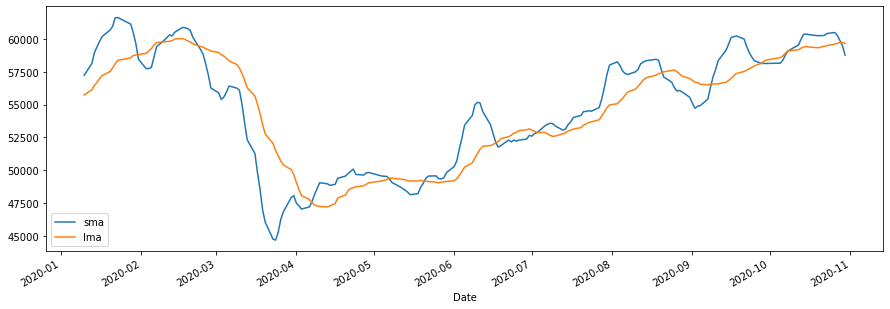

In [12]:
# df[['Close','sma','lma']].iloc[-200:].plot(figsize=(15,5))
df[['sma','lma']].iloc[-200:].plot(figsize=(15,5))

In [13]:
df.head()

,Open,High,Low,Close,Volume,Change,sma,lma
Date,,,,,,,,
2010-01-29,16000,16019,15600,15680,457285,-0.029703,16196.0,16402.0
2010-02-01,15679,15700,15300,15540,501042,-0.008929,15936.0,16370.0
2010-02-02,15800,15800,15400,15440,393803,-0.006435,15764.0,16320.0
2010-02-03,15640,15700,15360,15540,330235,0.006477,15672.0,16256.0
2010-02-04,15500,15660,15440,15520,239799,-0.001287,15544.0,16219.0


In [14]:
df['position'] = np.where(df['sma'] >= df['lma'], 1, 0)

In [15]:
df

,Open,High,Low,Close,Volume,Change,sma,lma,position
Date,,,,,,,,,
2010-01-29,16000,16019,15600,15680,457285,-0.029703,16196.0,16402.0,0
2010-02-01,15679,15700,15300,15540,501042,-0.008929,15936.0,16370.0,0
2010-02-02,15800,15800,15400,15440,393803,-0.006435,15764.0,16320.0,0
2010-02-03,15640,15700,15360,15540,330235,0.006477,15672.0,16256.0,0
2010-02-04,15500,15660,15440,15520,239799,-0.001287,15544.0,16219.0,0
...,...,...,...,...,...,...,...,...,...
2020-10-26,60400,61100,60100,60400,13268226,0.003322,60500.0,59610.0,1
2020-10-27,60300,60300,59500,59800,17260416,-0.009934,60280.0,59670.0,1
2020-10-28,59400,59400,58800,59000,14428882,-0.013378,59900.0,59730.0,1


<AxesSubplot:xlabel='Date'>

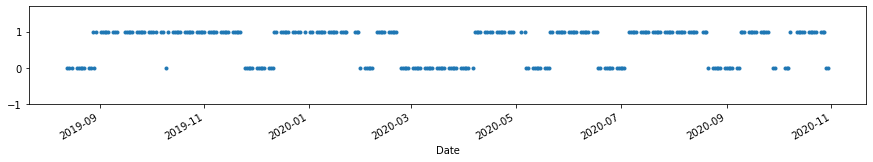

In [16]:
df['position'][-300:].plot(marker='.', linestyle='none', figsize=(15,2), ylim=[-1.01, 1.7])

In [17]:
long_index = df[(df['position'] - df['position'].shift(1)) == 1].index
exit_index = df[(df['position'] - df['position'].shift(1)) == -1].index

<AxesSubplot:xlabel='Date'>

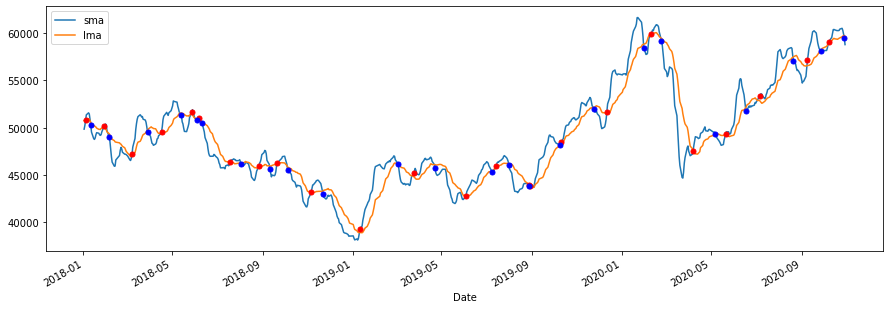

In [18]:
# df[['Close']].loc['2020-01-01':].plot(figsize=(15,5), color='black')
df[['sma','lma']].loc['2018-01-01':].plot(figsize=(15,5))
df.loc[long_index, 'sma'].loc['2018-01-01':].plot(marker='o', color='red', linestyle='none', markersize=5)
df.loc[exit_index, 'sma'].loc['2018-01-01':].plot(marker='o', color='blue', linestyle='none', markersize=5)

In [19]:
df.loc[:, 'rtn'] = get_returns_df(df['Close'], N=1, log=True)
df

,Open,High,Low,Close,Volume,Change,sma,lma,position,rtn
Date,,,,,,,,,,
2010-01-29,16000,16019,15600,15680,457285,-0.029703,16196.0,16402.0,0,0.000000
2010-02-01,15679,15700,15300,15540,501042,-0.008929,15936.0,16370.0,0,-0.008969
2010-02-02,15800,15800,15400,15440,393803,-0.006435,15764.0,16320.0,0,-0.006456
2010-02-03,15640,15700,15360,15540,330235,0.006477,15672.0,16256.0,0,0.006456
2010-02-04,15500,15660,15440,15520,239799,-0.001287,15544.0,16219.0,0,-0.001288
...,...,...,...,...,...,...,...,...,...,...
2020-10-26,60400,61100,60100,60400,13268226,0.003322,60500.0,59610.0,1,0.003317
2020-10-27,60300,60300,59500,59800,17260416,-0.009934,60280.0,59670.0,1,-0.009983
2020-10-28,59400,59400,58800,59000,14428882,-0.013378,59900.0,59730.0,1,-0.013468


In [20]:
df.loc[:, 'str_rtn'] = (df['position'].shift(1) * df['rtn']).fillna(0)

In [21]:
df.loc[:, 'cum_str_rtn'] = get_cum_returns_df(df['str_rtn'], log=True)
df

,Open,High,Low,Close,Volume,Change,sma,lma,position,rtn,str_rtn,cum_str_rtn
Date,,,,,,,,,,,,
2010-01-29,16000,16019,15600,15680,457285,-0.029703,16196.0,16402.0,0,0.000000,0.000000,1.000000
2010-02-01,15679,15700,15300,15540,501042,-0.008929,15936.0,16370.0,0,-0.008969,-0.000000,1.000000
2010-02-02,15800,15800,15400,15440,393803,-0.006435,15764.0,16320.0,0,-0.006456,-0.000000,1.000000
2010-02-03,15640,15700,15360,15540,330235,0.006477,15672.0,16256.0,0,0.006456,0.000000,1.000000
2010-02-04,15500,15660,15440,15520,239799,-0.001287,15544.0,16219.0,0,-0.001288,-0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26,60400,61100,60100,60400,13268226,0.003322,60500.0,59610.0,1,0.003317,0.003317,1.352149
2020-10-27,60300,60300,59500,59800,17260416,-0.009934,60280.0,59670.0,1,-0.009983,-0.009983,1.338717
2020-10-28,59400,59400,58800,59000,14428882,-0.013378,59900.0,59730.0,1,-0.013468,-0.013468,1.320808


In [24]:
cagr = get_cagr_series(df['cum_str_rtn'], num_day_in_year = 250)
sharp_ratio = get_sharpe_ratio(df['str_rtn'], yearly_rfr = 0.025)
mdd, ldd_period, ldd_st, ldd_ed = get_drawdown_infos(df['cum_str_rtn'])

In [25]:
print('cagr :', cagr)
print('sharp_ratio :', sharp_ratio)
print('Max_drawdown :', mdd)
print('Longest_dd_period :', ldd_period)
print('Longest_dd_st_date :', ldd_st)
print('Longest_dd_ed_date :', ldd_ed)

cagr : 0.02508052009815409
sharp_ratio : -0.00016068342693508565
Max_drawdown : -0.36030614769557534
Longest_dd_period : -1764
Longest_dd_st_date : 2013-01-02 00:00:00
Longest_dd_ed_date : 2017-11-01 00:00:00


<AxesSubplot:xlabel='Date'>

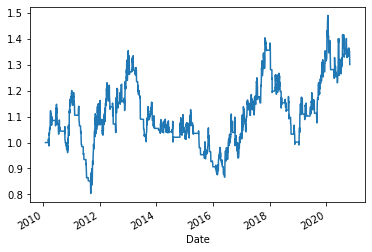

In [26]:
df.loc[:, 'cum_str_rtn'].plot()

### Momentum

In [27]:
df = fdr.DataReader('005930','2018-01-02','2022-04-29')

In [28]:
momentum_window=20*3

In [29]:
get_returns_df(df['Close'], N=momentum_window)

Date
2018-03-29    0.000000
2018-03-30   -0.035280
2018-04-02   -0.059667
2018-04-03   -0.057948
2018-04-04   -0.099770
                ...   
2022-04-25   -0.117177
2022-04-26   -0.106757
2022-04-27   -0.113233
2022-04-28   -0.091164
2022-04-29   -0.087312
Name: Close, Length: 1007, dtype: float64

In [30]:
position = np.sign(get_returns_df(df['Close'], N=momentum_window))
position.head()

Date
2018-03-29    0.0
2018-03-30   -1.0
2018-04-02   -1.0
2018-04-03   -1.0
2018-04-04   -1.0
Name: Close, dtype: float64

In [31]:
position.value_counts()

 1.0    537
-1.0    465
 0.0      5
Name: Close, dtype: int64

In [32]:
position[position == -1] = 0

In [33]:
position.value_counts()

1.0    537
0.0    470
Name: Close, dtype: int64

<AxesSubplot:xlabel='Date'>

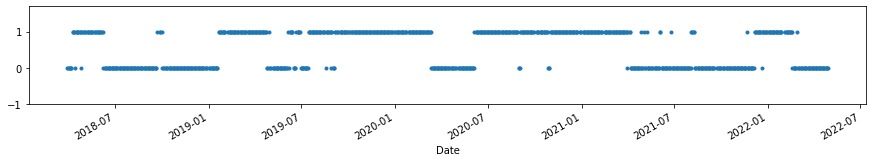

In [34]:
position.plot(marker='.', linestyle='none', figsize=(15,2), ylim=[-1.01, 1.7])

In [35]:
df.loc[:, 'position'] = position

In [36]:
df.dropna(inplace=True)

In [37]:
long_index = df[(df['position'] - df['position'].shift(1)) == 1].index
exit_index = df[(df['position'] - df['position'].shift(1)) == -1].index

<AxesSubplot:xlabel='Date'>

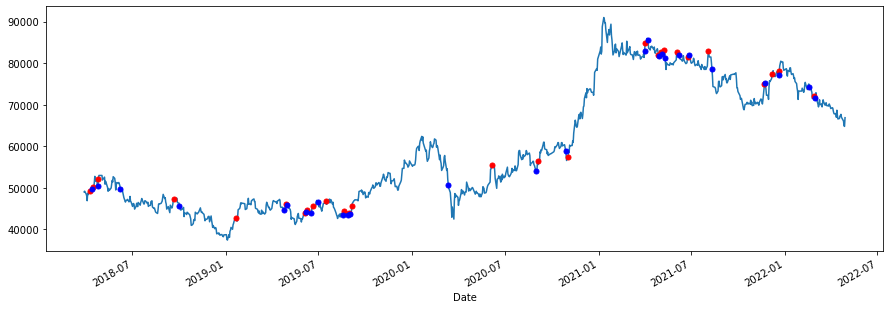

In [38]:
ax = df.loc[:, 'Close'].loc['2018-01-01':].plot(figsize=(15,5))

df.loc[long_index, 'Close'].loc['2018-01-01':].plot(ax=ax, marker='o', color='red', linestyle='none', markersize=5)
df.loc[exit_index, 'Close'].loc['2018-01-01':].plot(ax=ax, marker='o', color='blue', linestyle='none', markersize=5)

In [39]:
df.loc[:, 'rtn'] = get_returns_df(df['Close'], N=1, log=True)
df.loc[:, 'str_rtn'] = (df['position'].shift(1) * df['rtn']).fillna(0)

df.loc[:, 'cum_str_rtn'] = get_cum_returns_df(df['str_rtn'], log=True)

In [40]:
df

,Open,High,Low,Close,Volume,Change,position,rtn,str_rtn,cum_str_rtn
Date,,,,,,,,,,
2018-03-29,48700,49560,48320,49040,201340,0.006982,0.0,0.000000,0.0,1.00000
2018-03-30,49080,49900,49080,49220,155542,0.003670,0.0,0.003664,0.0,1.00000
2018-04-02,49000,49220,48500,48540,142313,-0.013816,0.0,-0.013912,-0.0,1.00000
2018-04-03,47880,48140,47280,48120,255365,-0.008653,0.0,-0.008690,-0.0,1.00000
2018-04-04,48160,48260,46920,46920,247684,-0.024938,0.0,-0.025254,-0.0,1.00000
...,...,...,...,...,...,...,...,...,...,...
2022-04-25,66500,66700,66300,66300,11016474,-0.010448,0.0,-0.010503,-0.0,1.24892
2022-04-26,66400,66700,66100,66100,12946923,-0.003017,0.0,-0.003021,-0.0,1.24892
2022-04-27,65400,65500,64900,65000,18122084,-0.016641,0.0,-0.016781,-0.0,1.24892


In [43]:
cagr = get_cagr_series(df['cum_str_rtn'], num_day_in_year = 250)
sharp_ratio = get_sharpe_ratio(df['str_rtn'], yearly_rfr = 0.025)
mdd, ldd_period, ldd_st, ldd_ed = get_drawdown_infos(df['cum_str_rtn'])

In [44]:
print('cagr :', cagr)
print('sharp_ratio :', sharp_ratio)
print('Max_drawdown :', mdd)
print('Longest_dd_period :', ldd_period)
print('Longest_dd_st_date :', ldd_st)
print('Longest_dd_ed_date :', ldd_ed)

cagr : 0.05673457282832617
sharp_ratio : 0.16520368873398802
Max_drawdown : -0.2680411180411182
Longest_dd_period : -607
Longest_dd_st_date : 2018-04-19 00:00:00
Longest_dd_ed_date : 2019-12-17 00:00:00


<AxesSubplot:xlabel='Date'>

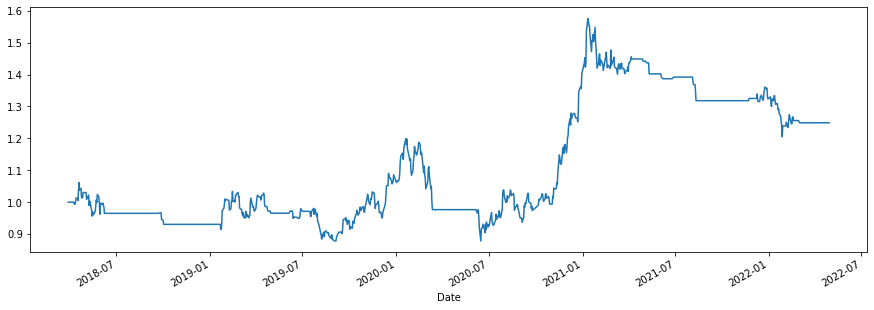

In [45]:
df.loc[:, 'cum_str_rtn'].plot(figsize=(15,5))

In [48]:
def momentum(df, mw):
    
    momentum_window=mw
    
    position = np.sign(get_returns_df(df['Close'], N=momentum_window))
    position[position == -1] = 0
    
    df.loc[:, 'position'] = position
    df.dropna(inplace=True)
    
    df.loc[:, 'rtn'] = get_returns_df(df['Close'], N=1, log=True)
    df.loc[:, 'str_rtn'] = (df['position'].shift(1) * df['rtn']).fillna(0)

    df.loc[:, 'cum_str_rtn'] = get_cum_returns_df(df['str_rtn'], log=True)
    
    cagr = get_cagr_series(df['cum_str_rtn'], num_day_in_year = 250)
    sharp_ratio = get_sharpe_ratio(df['str_rtn'], yearly_rfr = 0.025)
    mdd, ldd_period, ldd_st, ldd_ed = get_drawdown_infos(df['cum_str_rtn'])
    
    print('cagr :', cagr)
    print('sharp_ratio :', sharp_ratio)
    print('Max_drawdown :', mdd)
    print('Longest_dd_period :', ldd_period)
    print('Longest_dd_st_date :', ldd_st)
    print('Longest_dd_ed_date :', ldd_ed)
    
    df.loc[:, 'cum_str_rtn'].plot(figsize=(15,5))

cagr : -0.01443062614986812
sharp_ratio : -0.11613861219199131
Max_drawdown : -0.5940000597344159
Longest_dd_period : -13
Longest_dd_st_date : 2018-05-15 00:00:00
Longest_dd_ed_date : 2018-05-28 00:00:00


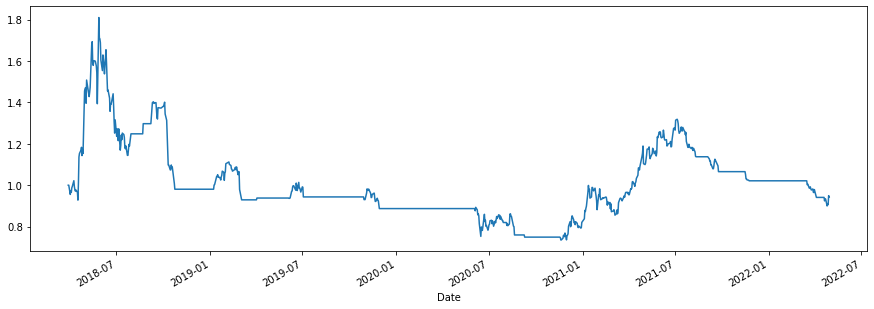

In [49]:
df = fdr.DataReader('000720','2018-01-02','2022-04-29')
mw = 60

momentum(df, mw)

### Mean-Reversion전략

In [75]:
df = fdr.DataReader('005930', '2020-01-02', '2022-04-30')
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,55500,56000,55000,55200,12993228,-0.010753
2020-01-03,56000,56600,54900,55500,15422255,0.005435
2020-01-06,54900,55600,54600,55500,10278951,0.000000
2020-01-07,55700,56400,55600,55800,10009778,0.005405
2020-01-08,56200,57400,55900,56800,23501171,0.017921


In [76]:
df = df[['Close']]
df

,Close
Date,
2020-01-02,55200
2020-01-03,55500
2020-01-06,55500
2020-01-07,55800
2020-01-08,56800
...,...
2022-04-25,66300
2022-04-26,66100
2022-04-27,65000


In [77]:
window = 20
df.loc[:, 'sma'] = df['Close'].rolling(window).mean()

In [78]:
rolling_std = df['Close'].rolling(window).std()

In [79]:
df.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

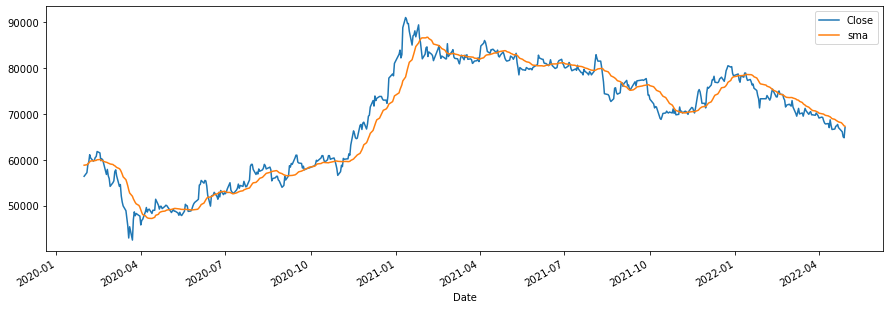

In [80]:
df.plot(figsize=(15,5))

In [81]:
df['+threshold'] = df['sma'] + 2*rolling_std
df['-threshold'] = df['sma'] - 2*rolling_std

In [82]:
df.head()

,Close,sma,+threshold,-threshold
Date,,,,
2020-01-31,56400,58815.0,63526.140213,54103.859787
2020-02-03,57200,58915.0,63381.612987,54448.387013
2020-02-04,58900,59085.0,63253.187793,54916.812207
2020-02-05,59500,59285.0,63097.596850,55472.403150
2020-02-06,61100,59550.0,63068.073636,56031.926364


<AxesSubplot:xlabel='Date'>

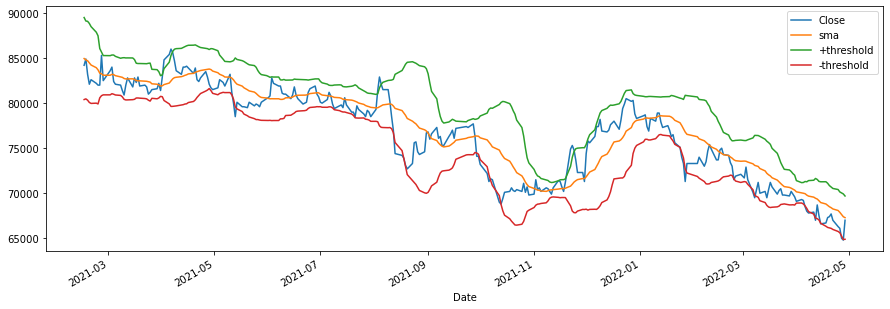

In [83]:
df[['Close', 'sma', '+threshold', '-threshold']].iloc[-300:].plot(figsize=(15,5))

In [84]:
pos1 = np.where(df['Close'] <= df['-threshold'], 1, 0)
pos2 = np.where(df['Close'] >= df['+threshold'], -1, 0)

df.loc[:, 'position'] = pos1 + pos2

In [85]:
df

,Close,sma,+threshold,-threshold,position
Date,,,,,
2020-01-31,56400,58815.0,63526.140213,54103.859787,0
2020-02-03,57200,58915.0,63381.612987,54448.387013,0
2020-02-04,58900,59085.0,63253.187793,54916.812207,0
2020-02-05,59500,59285.0,63097.596850,55472.403150,0
2020-02-06,61100,59550.0,63068.073636,56031.926364,0
...,...,...,...,...,...
2022-04-25,66300,68085.0,70412.207498,65757.792502,0
2022-04-26,66100,67880.0,70144.229856,65615.770144,0
2022-04-27,65000,67635.0,70035.241216,65234.758784,1


<AxesSubplot:xlabel='Date'>

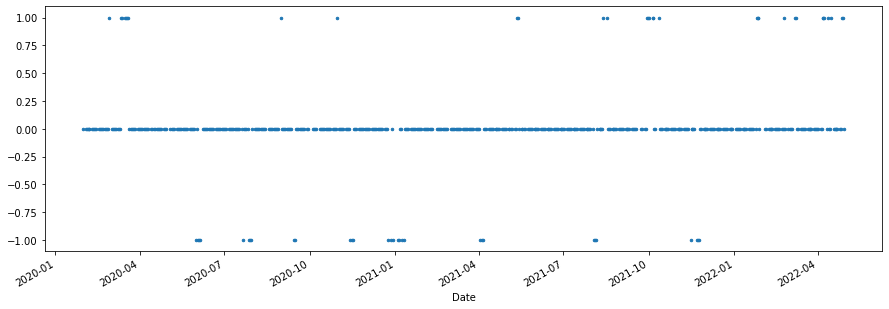

In [86]:
df['position'].plot(
    marker='.', linestyle='none', markersize=5, figsize=(15,5)
)

In [87]:
short_index = df[
    ((df['position'] - df['position'].shift()) == -1) & (df['position'] == -1)
].index

short_index


DatetimeIndex(['2020-06-01', '2020-06-03', '2020-07-21', '2020-07-28',
               '2020-09-14', '2020-11-13', '2020-12-24', '2020-12-30',
               '2021-01-08', '2021-04-02', '2021-08-03', '2021-11-15',
               '2021-11-22'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [88]:
long_index = df[
    ((df['position'] - df['position'].shift()) ==1) & (df['position'] == 1)
].index

long_index

DatetimeIndex(['2020-02-28', '2020-03-12', '2020-08-31', '2020-10-30',
               '2021-05-12', '2021-08-13', '2021-09-29', '2021-10-12',
               '2022-01-25', '2022-02-24', '2022-03-07', '2022-04-06',
               '2022-04-12', '2022-04-15', '2022-04-27'],
              dtype='datetime64[ns]', name='Date', freq=None)

<AxesSubplot:xlabel='Date'>

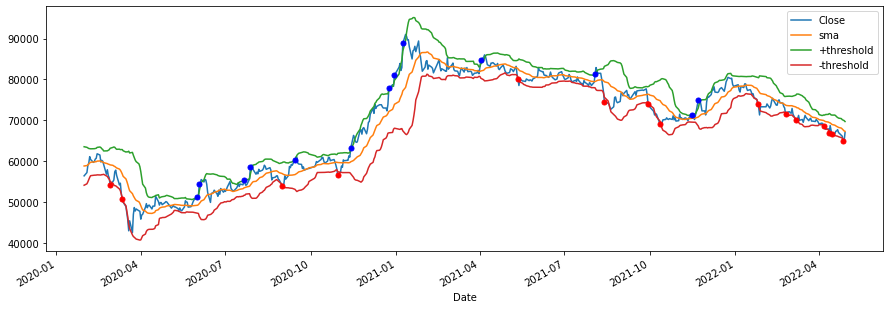

In [89]:
ax = df[['Close', 'sma', '+threshold', '-threshold']].plot(figsize=(15,5))
df.loc[short_index, 'Close'].plot(ax=ax, marker='o', markersize=5, linestyle='none', color='blue')
df.loc[long_index, 'Close'].plot(ax=ax, marker='o', markersize=5, linestyle='none', color='red')

In [90]:
df['rtn'] = get_returns_df(df['Close'], log=True)
df['str_rtn'] = (df['position'].shift() * df['rtn']).fillna(0)

In [94]:
df.loc[:, 'cum_rtn'] = get_cum_returns_df(df['rtn'], log=True)
df.loc[:, 'str_cum_rtn'] = get_cum_returns_df(df['str_rtn'], log=True)

<AxesSubplot:xlabel='Date'>

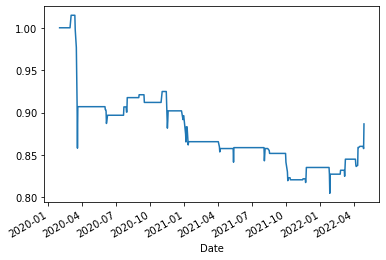

In [97]:
df['str_cum_rtn'].plot()

In [107]:
def backtest_eval(scr, sr):

    cagr = get_cagr_series(df[scr], num_day_in_year = 250)
    sharp_ratio = get_sharpe_ratio(df[sr], yearly_rfr = 0.025)
    mdd, ldd_period, ldd_st, ldd_ed = get_drawdown_infos(df[scr])

    print('cagr :', cagr)
    print('sharp_ratio :', sharp_ratio)
    print('Max_drawdown :', mdd)
    print('Longest_dd_period :', ldd_period)
    print('Longest_dd_st_date :', ldd_st)
    print('Longest_dd_ed_date :', ldd_ed)

In [108]:
cr = 'str_cum_rtn'
sr = 'str_rtn'

backtest_eval(cr, sr)

cagr : -0.052615319332170896
sharp_ratio : -0.7946427288757496
Max_drawdown : -0.2070170212747433
Longest_dd_period : -3
Longest_dd_st_date : 2020-01-31 00:00:00
Longest_dd_ed_date : 2020-02-03 00:00:00


### 변동성 돌파 전략..

In [109]:
df = fdr.DataReader('005930', '2020-01-02', '2022-04-30')
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,55500,56000,55000,55200,12993228,-0.010753
2020-01-03,56000,56600,54900,55500,15422255,0.005435
2020-01-06,54900,55600,54600,55500,10278951,0.000000
2020-01-07,55700,56400,55600,55800,10009778,0.005405
2020-01-08,56200,57400,55900,56800,23501171,0.017921


In [111]:
df = df[['Open', 'High', 'Close', 'Low']]

In [114]:
df['range'] = df['High'] - df['Low']
df['threshold'] = df['Open'] + df['range'].shift()*0.6
df.head()

,Open,High,Close,Low,range,threshold
Date,,,,,,
2020-01-02,55500,56000,55200,55000,1000,NaN
2020-01-03,56000,56600,55500,54900,1700,56600.0
2020-01-06,54900,55600,55500,54600,1000,55920.0
2020-01-07,55700,56400,55800,55600,800,56300.0
2020-01-08,56200,57400,56800,55900,1500,56680.0


In [115]:
df.dropna(inplace=True)

In [116]:
cond = df['threshold'] <= df['High']
df['position'] = cond.astype(int)

In [117]:
df

,Open,High,Close,Low,range,threshold,position
Date,,,,,,,
2020-01-03,56000,56600,55500,54900,1700,56600.0,1
2020-01-06,54900,55600,55500,54600,1000,55920.0,0
2020-01-07,55700,56400,55800,55600,800,56300.0,1
2020-01-08,56200,57400,56800,55900,1500,56680.0,1
2020-01-09,58400,58600,58600,57400,1200,59300.0,0
...,...,...,...,...,...,...,...
2022-04-25,66500,66700,66300,66300,400,66860.0,0
2022-04-26,66400,66700,66100,66100,600,66640.0,1
2022-04-27,65400,65500,65000,64900,600,65760.0,0


In [118]:
p_current = df['Open']
p_prev = df['threshold'].shift()
df['rtn'] = p_current/ p_prev -1

In [119]:
df

,Open,High,Close,Low,range,threshold,position,rtn
Date,,,,,,,,
2020-01-03,56000,56600,55500,54900,1700,56600.0,1,NaN
2020-01-06,54900,55600,55500,54600,1000,55920.0,0,-0.030035
2020-01-07,55700,56400,55800,55600,800,56300.0,1,-0.003934
2020-01-08,56200,57400,56800,55900,1500,56680.0,1,-0.001776
2020-01-09,58400,58600,58600,57400,1200,59300.0,0,0.030346
...,...,...,...,...,...,...,...,...
2022-04-25,66500,66700,66300,66300,400,66860.0,0,-0.017435
2022-04-26,66400,66700,66100,66100,600,66640.0,1,-0.006880
2022-04-27,65400,65500,65000,64900,600,65760.0,0,-0.018607


In [120]:
df['str_rtn'] = df['position'].shift() * df['rtn']
df['str_rtn'] = df['str_rtn'].fillna(0)

In [121]:
df.loc[:, 'str_cum_rtn'] = get_cum_returns_df(df['str_rtn'], log=False)

<AxesSubplot:xlabel='Date'>

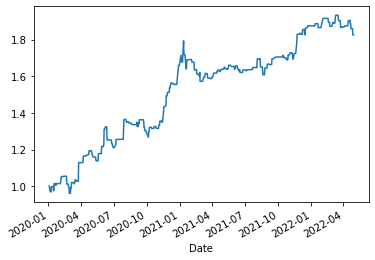

In [123]:
df['str_cum_rtn'].plot()

In [124]:
cr = 'str_cum_rtn'
sr = 'str_rtn'

backtest_eval(cr, sr)

cagr : 0.2992110530693959
sharp_ratio : 1.4282388585691228
Max_drawdown : -0.12318200796557954
Longest_dd_period : -316
Longest_dd_st_date : 2021-01-11 00:00:00
Longest_dd_ed_date : 2021-11-23 00:00:00
